**извлечение признаков из текста на естественном языке**

кластеризатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
900,Белорусская православная церковь все-таки снесет два здания 19 века под свой комплекс на Обойной\n\n7 декабря 2016 в 14:49\n\nЕлена Толкачева / REALTY.TUT.BY\n\nМногофункциональный духовно-просвет...,realty
2074,"Вчера, 12 декабря, на НСК ""Олимпийский"" состоялась церемония ""Футбольные звезды Украины-2016"".\n\nПо итогам голосования футболистом года признан полузащитник ""Динамо"" Андрей Ярмоленко. На втором м...",sport


---

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [8]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 18.7 s, sys: 44.1 ms, total: 18.7 s
Wall time: 18.8 s


In [9]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [10]:
data[['text_clean']].sample(2)

,text_clean
580,поставск район столкнул грузовик renault пострада человек декабр aut tut человек получ травм различн степен тяжест дтп котор произошл днем ноябр вблиз деревн детков поставск район фот мчс сообщ мч...
2301,точн сумм определ индивидуальн исход ущерб имуществ вред здоров след недел начнут выплат компенсац пострада взрыв бытов газ советск гаван сообща порта губерн ссылк пресс служб правительств хабаров...


##  CountVectorizer + TF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tf = TfidfVectorizer(use_idf=True,norm='l2')
# tf = TfidfVectorizer(use_idf=False,norm='l2')

tf.fit( data['text_clean'] )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [13]:
len(tf.vocabulary_)

34798

## формируем датасет

In [14]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 34798)

## обучаем

In [16]:
from sklearn.cluster import KMeans

In [18]:
%%time

n_clusters = len(set(data['tag']))
clust = KMeans(n_clusters=n_clusters, random_state=622 )
clust.fit(X)

CPU times: user 50.2 s, sys: 49.8 ms, total: 50.3 s
Wall time: 42.3 s


In [19]:
data['cluster'] = clust.labels_

## тестируем

In [25]:
from matplotlib import pyplot as plt

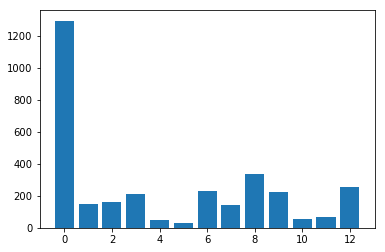

In [27]:
# размеры кластеров
b = [ (data['cluster']==c).sum() for c in range(n_clusters) ]
plt.bar(range(len(b)),b)
plt.show()

In [29]:
data[ data['cluster']==0 ][['text','tag']].sample(10)

,text,tag
619,"7 женщин, которых любил команданте Кастро\n\n3 декабря 2016 в 9:30\n\napril-knows.ru\n\nКубинцы не зря дали своему команданте прозвище Эль-Кабальо — Жеребец. По подсчетам неофициальных биографов, ...",woman
207,В Лондоне открылась выставка русской пикториальной фотографии В лондонском\nСомерсет-хаусе открылась выставка уникальной русской и ранней советской\nпикториальной фотографии. Всего в экспозиции пр...,culture
1285,"Елка из истребителей: необычное поздравление от ВВС Швеции\n\n8 декабря 2016 в 16:43\n\nДенис Алдохин / 42.TUT.BY\n\nСегодня в небе Швеции можно было наблюдать рождественскую елку, построенную из ...",social
2409,"ВАШИНГТОН, 12 дек – РИА Новости. Песней, танцами и легкостью может запомниться 2016 киногод: мюзикл ""Ла-ла-ленд"" ожидаемо получил большинство номинаций на премию Ассоциации зарубежных журналистов ...",culture
3175,"Голос России - новости На Чукотке открылся фестиваль морских охотников\n""Берингия"" Культурно-спортивный фестиваль морских охотников ""Берингия""\nоткрылся сегодня на Чукотке. Туда съехались лучшие м...",culture
2585,"РИАМО - 13 дек. Полная Луна помешает москвичам и жителям Подмосковья наблюдать звездопад Геминиды в ночь на 14 декабря, сообщил РИАМО во вторник представитель пресс-службы Московского планетария.\...",science
430,Глава британской разведки МИ-6: Россия препятствует борьбе с ИГ\n\n8 декабря 2016 в 18:57\n\nРусская служба Би-би-си\n\nДжихадисты экстремистской группировки «Исламское государство» планируют напа...,politics
988,Бывший помощник Лукашенко нашел работу у российского миллионера Брынцалова\n\n2 декабря 2016 в 20:15\n\nTUT.BY\n\nБелорус Сергей Ткачев вошел в состав наблюдательного совета ПАО «Брынцалов-А». Об ...,economics
751,Дешевле и без простоя на границе. Ecolines будет ездить из Минска в литовские аэропорты\n\n7 декабря 2016 в 17:44\n\nTUT.BY\n\nКомпания Ecolines с 22 декабря открывает регулярные рейсы в аэропорты...,social
832,Адвокат Маруани: Киркорову и его адвокату грозит по 5 лет тюрьмы\n\n30 ноября 2016 в 22:18\n\nRFI\n\nИстория с задержанием в Москве известного французского музыканта Дидье Маруани по подозрению в ...,social


In [22]:
data[ data['cluster']==1 ][['text','tag']].sample(10)

,text,tag
1977,"Победивший на президентских выборах 8 ноября Дональд Трамп собирается сделать своим главным экономическим советником банкира.\n\nТрамп возлагает большие надежды на Гэри Кона\n\nКак сообщают СМИ, р...",politics
1921,Президент США Барак Обама после ухода с поста будет арендовать офис в здании Всемирного фонда дикой природы (WWF). Соответствующий договор уже заключен.\n\nВ Белом Доме информацию об аренде Обамой...,politics
1833,"Избранный президент США Дональд Трамп перенес на январь 2017 года пресс-конференцию, на которой объявит о судьбе своей бизнес-империи после инаугурации, сообщает Bloomberg. По информации агентства...",politics
1832,"Пресс-конференция Трампа, на которой он должен был объявить о своем уходе из бизнеса, была перенесена с ближайшего четверга на начало следующего года.\n\nКак сообщает РИА ""Новости"", пресс-конферен...",politics
465,"Выборщик-республиканец из Техаса отказался голосовать за Трампа\n\n6 декабря 2016 в 7:06\n\nРусская служба Би-би-си\n\nЧлен коллегии выборщиков от штата Техас Крис Супрун, представляющий Республик...",politics
1933,"Избранный президент США Дональд Трамп намерен рассказать, как поступит со своей бизнес-империей, в январе 2017 года. Об этом сообщил представитель миллиардера Шон Спайсер, передает Reuters.\n\nТра...",politics
443,"""Президент Разделенных Штатов Америки"". ""Человеком года"" по версии Time стал Дональд Трамп\n\nопубликовано: 7 декабря 2016 в 15:40\n\nобновлено: 7 декабря 2016 в 18:32\n\nTUT.BY\n\nТрадиционно в д...",politics
1427,"В аппарате директора национальной разведки США не поддерживают выводов Центрального разведывательного управления (ЦРУ), которое допускает, что Дональд Трамп победил на президентских выборах в США ...",politics
1934,"Избранный президент США Дональд Трамп перенес на январь заявление о его планах по выходу из бизнеса, чтобы избежать конфликта интересов. Об этом сообщает агентство Reuters со ссылкой на прессс-сек...",politics
1948,"НЬЮ-ЙОРК, 13 декабря. /Корр. ТАСС Кирилл Волков/. Пересчет голосов, поданных на выборах президента США в штате Висконсин, завершен, республиканец Дональд Трамп признан на них победителем. Итоги пр...",politics


In [23]:
data[ data['cluster']==3 ][['text','tag']].sample(10)

,text,tag
2383,"Юридическим владельцем ""гелендвагена"" является 47-летний мужчина, который после наезда скрылся с места происшествия на другом автомобиле.\n\nУстановлена личность водителя, сбившего двух девочек во...",incident
2329,"По данным следствия, на момент аварии правоохранительница была в состоянии алкогольного опьянения.\n\nВ Следственном комитете сообщили, что сбившая насмерть двух пешеходов бывшая сотрудница МУ МВД...",incident
2341,"Под Ростовом на трассе М-4 ""Дон"" столкнулись два грузовика\n\nРОСТОВ-НА-ДОНУ, 12 дек — РИА Новости, Иван Капустин. Два грузовых автомобиля столкнулись на трассе М-4 ""Дон"" в Ростовской области, вод...",incident
537,"В Минске при столкновении автомобилей на дорогу вылетел ребенок, сидевший на переднем сиденье\n\n6 декабря 2016 в 11:44\n\nAUTO.TUT.BY\n\nАвария произошла 5 декабря, около 20.50, на пересечении пр...",incident
2179,"13.12.16 09:53\n\nКемерово. 13 декабря. ИНТЕРФАКС-СИБИРЬ - Бригада ""скорой помощи"", два спасателя и двое автомобилистов госпитализированы с травмами различной степени тяжести после ДТП на трассе ""...",incident
2307,"В больнице Хабаровска скончалась одна из пострадавших при взрыве газа в Советской Гавани, сообщает РИА Новости. ""Женщина скончалась сегодня ночью"", - сказал представитель КГБУЗ ""Краевая Клиническа...",incident
2362,"РИАМО - 13 дек. Дознаватель столичной полиции выпала из окна квартиры, расположенной на седьмом этаже жилого дома на улице Сумская в Москве, пострадавшая госпитализирована, сообщил РИАМО во вторни...",incident
550,"В Ивьевском районе лоб в лоб столкнулись Audi и Daewoo: один человек погиб, трое — пострадали\n\n4 декабря 2016 в 13:10\n\nAUTO.TUT.BY\n\nОдин человек погиб и еще три получили травмы различной сте...",incident
2243,"ОМСК, 13 декабря, РИА ФедералПресс. Следственный комитет нашел основания для возбуждения уголовного дела после смерти омского школьника на соревнованиях по баскетболу 5 ноября. Об этом сообщили в ...",incident
2345,"Сотрудники правоохранительных органов в частном доме в Ростове-на-Дону нашли тела трех человек, - сообщил источник в силовых структурах региона.\n\n""Все трое погибших - взрослые люди. Предположите...",incident
